In [29]:
import os
import sys
import math
import rasterio
from rasterio import features
from rasterio.features import rasterize, geometry_mask
from rasterio.transform import from_origin
import fiona
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import numpy as np

In [17]:
# Get the current working directory
current_dir = os.path.abspath('')

# Search for the 'constants.py' file starting from the current directory and moving up the hierarchy
project_root = current_dir
while not os.path.isfile(os.path.join(project_root, 'constants.py')):
    project_root = os.path.dirname(project_root)

# Add the project root to the Python path
sys.path.append(project_root)

In [18]:
from constants import CLEAN, DISSOLVED, STUDY_BOUNDARY_PATH, DATA_PATH, HANSEN_LOSSYEAR_FILEPATH

In [4]:
clean = gpd.read_file(CLEAN) # Import the final clean lup_dataset with empty properites included from qgis
dissolved = gpd.read_file(DISSOLVED) # clean was dissolved by year but also keeping features distinct providing limit boundaries of each property by put_id
study_boundary = gpd.read_file(STUDY_BOUNDARY_PATH)

# Clean up of dissolved dataset
Removing slivers, readding a lost property, 

In [5]:
dissolved = dissolved.drop(columns='fid')

In [6]:
output_crs = 'EPSG:4326'
output_extent = (-62.64186038139295, -25.354320073574613, -57.14929123970096, -19.287457970745013)
output_resolution = (0.00026949458523585647, -0.00026949458523585647)
study_boundary = study_boundary.to_crs(output_crs)
study_area_bounds = study_boundary.total_bounds

In [7]:
# Creates a  Polygons based one for each year of 2000 - 2012, this will be used to select the correspoding 10-year pixels.
clean_dissolve = dissolved #clean.dissolve('anho_capa', as_index=False)
# Clean Slivers
clean_dissolve.geometry = clean_dissolve.buffer(25, join_style= 2)
clean_dissolve.geometry = clean_dissolve.buffer(-25, join_style= 2)
clean_dissolve = clean_dissolve.reindex(columns=dissolved.columns)

In [8]:
# Create an empty GeoDataFrame to store the final processed properties
clean_years = gpd.GeoDataFrame(columns=dissolved.columns)

# Add polygons from the year 2000 to clean_years as the baseline
clean_years = pd.concat([clean_years, clean_dissolve[clean_dissolve['anho_capa'] == '2000']])
for year in range(2001, 2013):  # Loop from 2001 to 2012
    # Get polygons of the current year
    current_year_properties = clean_dissolve[clean_dissolve['anho_capa'] == str(year)]
    
    # Iterate over each polygons of the current year
    for idx, current_property in current_year_properties.iterrows():
        # Subtract geometries of older polygons from the current polygons
        for _, older_property in clean_years.iterrows():
            current_property['geometry'] = current_property['geometry'].difference(older_property['geometry'])
        
        # Append the "cut" current polygons to the clean_years GeoDataFrame
        clean_years = pd.concat([clean_years, current_property.to_frame().T])
clean_years.crs = dissolved.crs


In [9]:
# For Visual Check in Qgis


'''output_path = os.path.join(DATA_PATH,'processing')


# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    # Save the GeoDataFrame as a GeoPackage
# Define the filename for the GeoPackage

filename = os.path.join(output_path, "clean_years.gpkg")
clean_years.to_file(filename, driver="GPKG")'''

'output_path = os.path.join(DATA_PATH,\'processing\')\n\n\n# Create the directory if it doesn\'t exist\nif not os.path.exists(output_path):\n    os.makedirs(output_path)\n    # Save the GeoDataFrame as a GeoPackage\n# Define the filename for the GeoPackage\n\nfilename = os.path.join(output_path, "clean_years.gpkg")\nclean_years.to_file(filename, driver="GPKG")'

<Axes: >

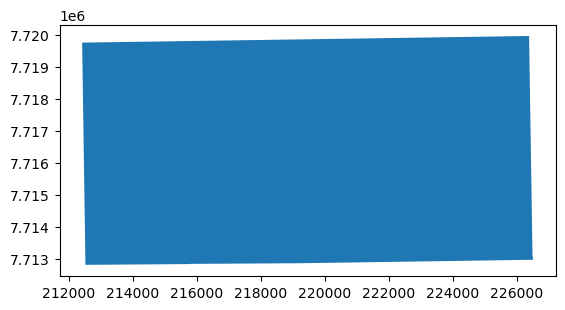

In [10]:
selected_row = clean.loc[clean['put_id'] == 'PUT2238']

selected_row_dissolved = selected_row.dissolve(by = 'anho_capa', as_index = False)
selected_row_dissolved.plot()

In [11]:
selected_row_dissolved.geometry = selected_row_dissolved.buffer(25, join_style= 2)
selected_row_dissolved.geometry = selected_row_dissolved.buffer(-25, join_style= 2)
selected_row_dissolved = selected_row_dissolved.reindex(columns=dissolved.columns)
selected_row_dissolved = selected_row_dissolved.drop(columns=['put_id', 'fecha_res', 'grupo'])

In [12]:
# Step 1: Filter out non-polygon geometries
clean_years_polygons = clean_years[clean_years['geometry'].apply(lambda geom: isinstance(geom, Polygon) or isinstance(geom, MultiPolygon))]

# Step 2: Dissolve the filtered GeoDataFrame
dissolved_clean_years = clean_years_polygons.dissolve(by='anho_capa', as_index=False)

dissolved_clean_years = dissolved_clean_years.reindex(columns=dissolved.columns)
dissolved_clean_years = dissolved_clean_years.drop(columns=['put_id', 'fecha_res', 'grupo'])



c:\ProgramData\Anaconda3\envs\policy\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [13]:
dissolved_clean_years = pd.concat([dissolved_clean_years, selected_row_dissolved], ignore_index=True)
# This is the final property limit dataset from here were create the spatial blocking dataset then to raster

In [14]:
# For Visual Check in Qgis


'''output_path = os.path.join(DATA_PATH,'processing')


# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    # Save the GeoDataFrame as a GeoPackage
# Define the filename for the GeoPackage

filename = os.path.join(output_path, "dissolved_clean_years.gpkg")
dissolved_clean_years.to_file(filename, driver="GPKG")'''

'output_path = os.path.join(DATA_PATH,\'processing\')\n\n\n# Create the directory if it doesn\'t exist\nif not os.path.exists(output_path):\n    os.makedirs(output_path)\n    # Save the GeoDataFrame as a GeoPackage\n# Define the filename for the GeoPackage\n\nfilename = os.path.join(output_path, "dissolved_clean_years.gpkg")\ndissolved_clean_years.to_file(filename, driver="GPKG")'

In [15]:
dissolved_clean_years

,anho_capa,geometry
0,2000,"MULTIPOLYGON (((16201.611 7458030.748, 16602.3..."
1,2001,"MULTIPOLYGON (((204574.289 7381696.025, 205859..."
2,2002,"MULTIPOLYGON (((179782.281 7420562.851, 178760..."
3,2003,"MULTIPOLYGON (((136574.646 7459039.163, 136579..."
4,2004,"MULTIPOLYGON (((116675.318 7385988.843, 116738..."
5,2005,"MULTIPOLYGON (((114903.996 7378608.585, 114946..."
6,2006,"MULTIPOLYGON (((88836.338 7430720.097, 88764.5..."
7,2007,"MULTIPOLYGON (((-36261.000 7512718.923, -36113..."
8,2008,"MULTIPOLYGON (((12754.176 7449722.872, 12756.0..."
9,2009,"MULTIPOLYGON (((59049.365 7403528.864, 59002.9..."


In [27]:
dissolved_clean_years = dissolved_clean_years.to_crs('EPSG:4326')

In [30]:
# Where files will save, can add subfolders if desired
output_dir = os.path.join(DATA_PATH, 'processed_rasters')
os.makedirs(output_dir, exist_ok=True)

In [32]:

# Load your raster data
with rasterio.open(HANSEN_LOSSYEAR_FILEPATH) as src:
    hansen_raster = src.read(1)  # Assuming lossyear is the first band
    profile = src.profile

    # Create an initial mask with all values set to -1
    modified_raster = np.full(hansen_raster.shape, -1, dtype=hansen_raster.dtype)

    # Process each polygon
    for index, row in dissolved_clean_years.iterrows():
        year = int(row['anho_capa'])  # Convert year to integer
        polygon = row['geometry']

        # Create a mask for the polygon
        polygon_mask = geometry_mask([polygon], transform=src.transform, invert=True, out_shape=src.shape)

        # Determine the range of years to keep
        start_year = year - 2000 + 1  # Adjust based on your data encoding
        end_year = start_year + 9

        # Apply the mask and modify values within the polygon
        within_polygon = (polygon_mask & (hansen_raster >= start_year) & (hansen_raster <= end_year))
        modified_raster[within_polygon] = hansen_raster[within_polygon]

    # Save the final modified raster
    with rasterio.open('final_modified_raster.tif', 'w', **profile) as dst:
        dst.write(modified_raster, 1)


# Vector to Raster

In [15]:
output_crs = 'EPSG:4326'
output_extent = (-62.64186038139295, -25.354320073574613, -57.14929123970096, -19.287457970745013)
output_resolution = (0.00026949458523585647, -0.00026949458523585647)
study_boundary = study_boundary.to_crs(output_crs)
study_area_bounds = study_boundary.total_bounds

In [16]:
def vector_to_raster(input_vector, output_raster, attribute, study_area_bounds, value_mapping, single_value=None, resolution=(abs(0.00026949458523585647), abs(-0.00026949458523585647)), dtype='uint16'):
    # Check if input_vector is a GeoDataFrame or a file path
    if isinstance(input_vector, gpd.GeoDataFrame):
        gdf = input_vector
    else:
        # Read the input vector file (GeoPackage or Shapefile) into a GeoDataFrame
        gdf = gpd.read_file(input_vector)
    # Reproject the GeoDataFrame to the desired CRS (EPSG:4326)
    gdf = gdf.to_crs(epsg=4326)

    # Ensure that categorical column is string
    gdf[attribute] = gdf[attribute].astype(str)
   

   # If single_value is None, convert the attribute column to numerical values
    # If single_value is provided, set the attribute column to the provided single_value
    if single_value is None:
        gdf[attribute] = gdf[attribute].replace(value_mapping).astype(dtype)
    else:
        gdf[attribute] = single_value


    # Use the study area bounds to define the dimensions and transform of the output raster
    minx, miny, maxx, maxy = study_area_bounds
    width = int(np.ceil((maxx - minx) / abs(resolution[0])))
    height = int(np.ceil((maxy - miny) / abs(resolution[1])))
    out_transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)


    # Define the metadata for the output raster file
    out_meta = {
        'driver': 'GTiff',
        'width': width,
        'height': height,
        'count': 1,
        'dtype': dtype,
        'crs': 'EPSG:4326',
        'transform': out_transform,
        'nodata': -1  # Set the nodata value
    }
    
    # Open the output raster file for writing with the specified metadata
    with rasterio.open(output_raster, 'w', **out_meta) as dst:
        # Create a generator of tuples containing the geometry and attribute value for each feature in the input vector data
        shapes = ((geom, value) for geom, value in zip(gdf['geometry'], gdf[attribute]))
        
        # Burn the geometries and their corresponding attribute values into a raster array
        burned = features.rasterize(
            shapes=shapes,         # The generator of geometry-attribute tuples
            fill=0,                # The default value for pixels not covered by any geometry
            out_shape=(height, width), # The shape of the output raster array (number of rows and columns)
            transform=out_transform,   # The affine transformation matrix that maps pixel coordinates to the coordinate reference system
            dtype=dtype,            # The data type of the raster array
            default_value=-1    # Set the nodata value
        )
        
        # Write the burned raster array to the output raster file
        dst.write(burned, 1)

In [17]:
# To write text file of value mapping
def write_value_mapping(value_mapping, output_file):
    with open(output_file, 'w') as f:
        for key, value in value_mapping.items():
            f.write(f'{key}: {value}\n')

In [18]:
def process_columns(input_vector, output_dir, study_area_bounds, resolution, columns, value_mapping, single_value=None, file_name=None):
    # Check if input_vector is a GeoDataFrame or a file path
    if isinstance(input_vector, gpd.GeoDataFrame):
        gdf = input_vector
        if file_name is None:
            file_name = "output"  # Set a default file name if none is provided
    else:
        # Read the input vector file (GeoPackage or Shapefile) into a GeoDataFrame
        gdf = gpd.read_file(input_vector)
        if file_name is None:
            file_name = os.path.splitext(os.path.basename(input_vector))[0]

    for column in columns:
        column_output_dir = os.path.join(output_dir, column)
        os.makedirs(column_output_dir, exist_ok=True)

        output_raster = f"{column_output_dir}/{file_name}_{column}_raster.tif"
        vector_to_raster(gdf, output_raster, column, study_area_bounds, value_mapping[column], single_value=single_value, resolution=resolution)


# Make Land Use Plan into Raster

In [20]:
def process_files(input_data, output_dir, study_area_bounds, resolution, columns, single_value=None):
    # Generate a global value mapping from the list of unique values for each column
    global_value_mapping = {column: set() for column in columns}
    
    if isinstance(input_data, str):
        gdf = gpd.read_file(input_data)
    elif isinstance(input_data, gpd.GeoDataFrame):
        gdf = input_data
    else:
        raise ValueError("Invalid input data type. Expected file path or GeoDataFrame.")
    
    for column in columns:
        global_value_mapping[column].update(gdf[column].astype(str).unique())
    
    for column in columns:
        global_value_mapping[column] = {value: idx for idx, value in enumerate(sorted(list(global_value_mapping[column])), 1)}
        print(f"Global value mapping for {column}:")
        for value in global_value_mapping[column]:
            print(f"{value}: {global_value_mapping[column][value]}")
    
    # Write the global value mapping for each column to separate .txt files in the corresponding column folder
    for column in columns:
        column_output_dir = os.path.join(output_dir, column)
        os.makedirs(column_output_dir, exist_ok=True)

        output_value_mapping_file = f"{column_output_dir}/{column}_global_value_mapping.txt"
        write_value_mapping(global_value_mapping[column], output_value_mapping_file)

    # Process the input data with the global value mapping
    process_columns(gdf, output_dir, study_area_bounds, columns=columns, resolution=resolution, value_mapping=global_value_mapping, single_value=single_value)


In [29]:


# Call the process_files function for the clean GeoDataFrame
process_files(clean, output_dir, study_area_bounds, output_resolution, columns = ['grupo'])


Global value mapping for grupo:
AREA_AUTORIZADA: 1
BOSQUES: 2
EN_CONFLICTO: 3
OTRAS_COBERTURAS: 4
OTRAS_TIERRAS_FORESTALES: 5
unclassified: 6


In [30]:
# Call the process_files function for the dissolved_clean_years GeoDataFrame
process_files(dissolved_clean_years, output_dir, study_area_bounds, output_resolution, columns = ['anho_capa'])

Global value mapping for anho_capa:
2000: 1
2001: 2
2002: 3
2003: 4
2004: 5
2005: 6
2006: 7
2007: 8
2008: 9
2009: 10
2010: 11
2011: 12
2012: 13


In [23]:
process_files(clean, output_dir, study_area_bounds, output_resolution, columns = ['put_id'])


Global value mapping for put_id:
PUT0001: 1
PUT0003: 2
PUT0007: 3
PUT0008: 4
PUT0009: 5
PUT0010: 6
PUT0011: 7
PUT0012: 8
PUT0013: 9
PUT0014: 10
PUT0016: 11
PUT0017: 12
PUT0018: 13
PUT0020: 14
PUT0021: 15
PUT0022: 16
PUT0023: 17
PUT0024: 18
PUT0026: 19
PUT0028: 20
PUT0029: 21
PUT0030: 22
PUT0031: 23
PUT0034: 24
PUT0036: 25
PUT0037: 26
PUT0039: 27
PUT0040: 28
PUT0041: 29
PUT0042: 30
PUT0045: 31
PUT0049: 32
PUT0050: 33
PUT0051: 34
PUT0059: 35
PUT0060: 36
PUT0061: 37
PUT0063: 38
PUT0071: 39
PUT0075: 40
PUT0077: 41
PUT0080: 42
PUT0082: 43
PUT0084: 44
PUT0089: 45
PUT0090: 46
PUT0091: 47
PUT0095: 48
PUT0097: 49
PUT0100: 50
PUT0101: 51
PUT0102: 52
PUT0103: 53
PUT0104: 54
PUT0105: 55
PUT0106: 56
PUT0107: 57
PUT0108: 58
PUT0109: 59
PUT0110: 60
PUT0111: 61
PUT0112: 62
PUT0113: 63
PUT0114: 64
PUT0116: 65
PUT0117: 66
PUT0118: 67
PUT0119: 68
PUT0121: 69
PUT0125: 70
PUT0126: 71
PUT0127: 72
PUT0129: 73
PUT0131: 74
PUT0132: 75
PUT0135: 76
PUT0136: 77
PUT0137: 78
PUT0138: 79
PUT0139: 80
PUT0140: 81
PUT0

# Training and Validation sets

In [ ]:
# Function to select properties for validation set based on distance constraint

def select_validation_set(gdf, distance_threshold=5000, validation_fraction=0.1):
    validation_set = []
    remaining_set = gdf.copy()
    
    while len(validation_set) < validation_fraction * len(gdf):
        # Randomly select a property
        selected_property = remaining_set.sample(1)
        
        # Append to validation set
        validation_set.append(selected_property)
        
        # Calculate distance between the boundary of the selected property and boundaries of remaining properties
        distances = remaining_set.boundary.distance(selected_property.boundary.squeeze())
        
        # Remove properties within the distance threshold from the remaining set
        remaining_set = remaining_set[distances > distance_threshold]
        
        # Break if no more properties can be added
        if len(remaining_set) == 0:
            break
    
    return gpd.GeoDataFrame(pd.concat(validation_set, ignore_index=True))

In [ ]:
# Get validation set
validation_gdf = select_validation_set(dissolved_clean_years)

# Get training set by excluding validation set
train_gdf = dissolved_clean_years[~dissolved_clean_years.index.isin(validation_gdf.index)]

print(f"Training set size: {len(train_gdf)}")
print(f"Validation set size: {len(validation_gdf)}")

# Save training set to a GeoPackage file
train_gdf.to_file("training_set.gpkg", driver="GPKG")

# Save validation set to a GeoPackage file
validation_gdf.to_file("validation_set.gpkg", driver="GPKG")